# Figure 4 script

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from carst.libdhdt import DemPile
import numpy as np
from datetime import datetime, timedelta
from carst.libdhdt import wl_reg as wlr
from carst.libdhdt import sigmoid_reg as smr
from carst.libdhdt import gp_reg as gpr
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import RationalQuadratic
from matplotlib.patches import BoxStyle

In [2]:
def load_data(datafolder):
    carst_inipath = datafolder + '/defaults.ini'

    pile = DemPile()
    pile.read_config(carst_inipath)
    pile.picklepath = datafolder + '/' + pile.picklepath
    pile.load_pickle()
    return pile

In [3]:
def read_single_pixel(pile, row=0, col=0, evmd_threshold=20, min_samples=3):
    exitstate, evmd_lbl = pile.ts[row, col].do_evmd(eps=evmd_threshold, min_samples=min_samples)
    
    bitmask_lbl = pile.ts[row, col].bitmask_labels
    good_idx = np.logical_and(bitmask_lbl == 0, evmd_lbl >= 0)
    arr = pile.ts[row, col]
    x = arr.get_date()
    y = arr.get_value()
    ye = arr.get_uncertainty()
    x_date = np.array([pile.refdate + timedelta(days=i) for i in x])
    return arr, evmd_lbl, bitmask_lbl, good_idx, x, y, ye, x_date

In [44]:
def plot_regression(pile, x, y, ye, x_date, good_idx, ax=None, which='wlr', downward_first=True):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    ax.errorbar(x_date, y, yerr=ye * 2, linewidth=2, fmt='k.')
    x_good = x[good_idx]
    y_good = y[good_idx]
    ye_good = ye[good_idx]

    if which == 'wlr':
        x_pred, y_pred, slope, slope_stderr, duration, exitstate = wlr(x_good, y_good, ye=ye_good)
    elif which == 'smr':
        k_bounds = [10, 150]
        x_pred, y_pred, sigmoid_height, sigmoid_height_stderr, sigmoid_timing, exitstate = smr(x_good, y_good, ye=ye_good, k_bounds=k_bounds, downward_first=downward_first)
    elif which == 'gpr':
        gp_kernel = ConstantKernel(constant_value=1, constant_value_bounds=[0.03, 30]) * RationalQuadratic(
                           length_scale=0.4, alpha=0.01, alpha_bounds='fixed', length_scale_bounds='fixed')
        x_pred, y_pred, y_pred_std, max_transient_dh, max_transient_dh_stderr, max_transient_timing, exitstate, actual_kernel = gpr(
            x_good, y_good, ye=ye_good, kernel=gp_kernel, return_ystd=True)
    else:
        print('WARNING')
    # ax.set_title(f'dh/dt (2-sigma) = {slope:.2f}±{2 * slope_stderr:.2f} m/yr' )
    x_pred_date = [pile.refdate + timedelta(days=i) for i in x_pred]
    ax.plot(x_pred_date, y_pred, color='g', linewidth=2, zorder=20)
    x_good_date = [pile.refdate + timedelta(days=i) for i in x_good]
    square_handle = ax.plot(x_good_date, y_good, 's', color='k', markersize=7, zorder=5)
    return square_handle

In [47]:
def plot_data_quality(x_date, y, good_idx, ax=None):
    """
    Two-colored version:
    Lilac square: Good data
    Yellow circle: Suboptimal data
    """
    if ax is None:
        _, ax = plt.subplots(1, 1)
    colorcodes = ['xkcd:lilac', 'xkcd:yellow']
    comments = ['Good', 'Suboptimal']
    # selected_group_index = good_idx == 1
    lilac_handle = ax.plot(x_date[good_idx], y[good_idx], '.', color=colorcodes[0], 
                markersize=12, markeredgewidth=1, markeredgecolor='k', zorder=10, label=comments[0])
    # selected_group_index = good_idx != 1
    yellow_handle = ax.plot(x_date[~good_idx], y[~good_idx], '.', color=colorcodes[1], 
                markersize=12, markeredgewidth=1, markeredgecolor='k', zorder=11, label=comments[1])
    return lilac_handle, yellow_handle

In [40]:
def plot_arcticdem_bitmask(x_date, y, bitmask_lbl, ax=None):
    """
    Not used. Two-colored version.
    """
    if ax is None:
        _, ax = plt.subplots(1, 1)
    bitmask_colorcodes = ['xkcd:lilac', 'xkcd:yellow']
    bitmask_comments = ['Good', 'Suboptimal']
    selected_group_index = bitmask_lbl == 0
    ax.plot(x_date[selected_group_index], y[selected_group_index], '.', color=bitmask_colorcodes[0], 
                markersize=12, markeredgewidth=1, markeredgecolor='k', zorder=10, label=bitmask_comments[0])
    selected_group_index = bitmask_lbl != 0
    ax.plot(x_date[selected_group_index], y[selected_group_index], '.', color=bitmask_colorcodes[1], 
                markersize=12, markeredgewidth=1, markeredgecolor='k', zorder=11, label=bitmask_comments[1])

In [6]:
def format_fn(tick_val, tick_pos):
    datetime_obj = mdates.num2date(tick_val)
    if datetime_obj.year % 2 == 1:
        return datetime_obj.strftime('%Y')
    else:
        return ''
        
def plot_adjustments(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(format_fn)
    # ax.xaxis.set_minor_locator(mdates.MonthLocator())
    
    plt.setp(ax.get_xticklabels(), rotation=-90, ha='center')
    ax.grid(axis='both', linestyle='--', color='xkcd:light grey')
    ax.tick_params(length=6)
    # ax.set_xlabel('pixel location = [{}, {}]'.format(row, col))
    # ax.set_ylabel('height (m)')

In [12]:
axes_settings = {'linewidth'   : 1.5}
mpl.rc('axes', **axes_settings)
font_settings = {'size'   : 13}
mpl.rc('font', **font_settings)

In [14]:
data_list = [['../JolliffeNArm', {'row': 738, 'col': 328, 'evmd_threshold': 20, 'min_samples': 3}],
             ['../TaggartLake', {'row': 922, 'col': 1409, 'evmd_threshold': 20, 'min_samples': 3}],
             ['../PennyW', {'row': 1553, 'col': 732, 'evmd_threshold': 20, 'min_samples': 3}],
             ['../AgassizSWMinor1', {'row': 153, 'col': 345, 'evmd_threshold': 20, 'min_samples': 3}],
             ['../MittieMain', {'row': 663, 'col': 552, 'evmd_threshold': 20, 'min_samples': 3}],
             ['../UnnamedHSE', {'row': 250, 'col': 459, 'evmd_threshold': 20, 'min_samples': 3}],
             ['../GoodFriday', {'row': 562, 'col': 803, 'evmd_threshold': 20, 'min_samples': 3}],
             ['../OttoN', {'row': [411, 362], 'col': [202, 247], 'evmd_threshold': 20, 'min_samples': 3}],
            ]

pile_data = []

for (datafolder, _) in data_list:
    pile_data.append(load_data(datafolder))

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


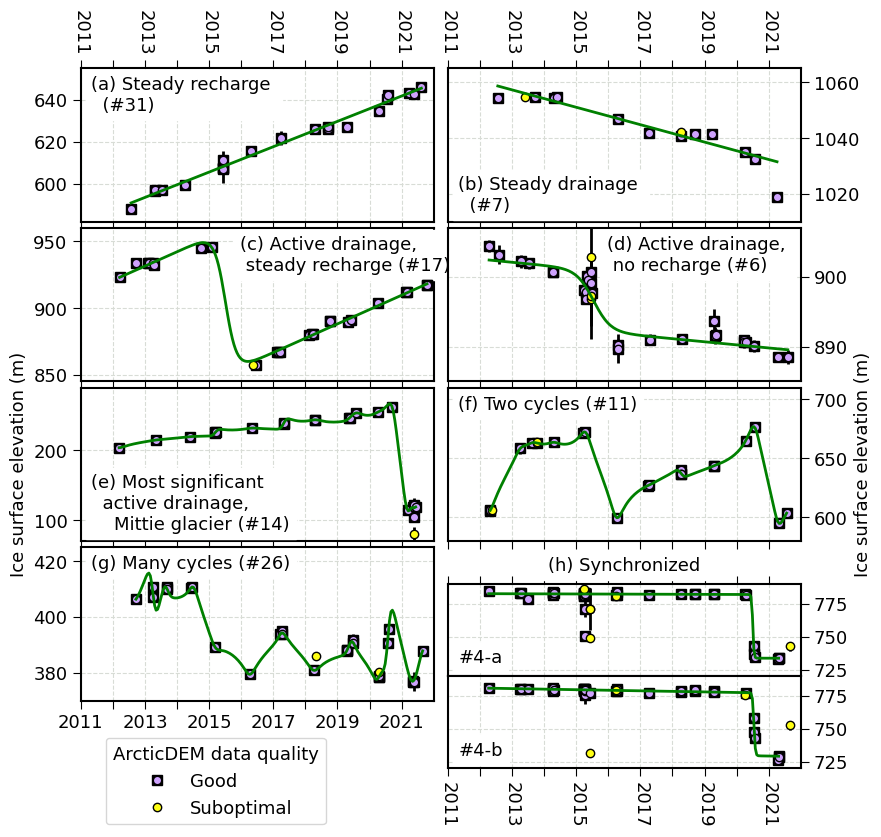

In [54]:
ylim_adjustment = [[582, 655], [1010, 1065], [845, 960], [885, 907], [70, 290], [580, 710], [370, 425]]  
reg_mode = ['wlr', 'wlr', 'smr', 'smr', 'gpr', 'gpr', 'gpr']

fig, axs = plt.subplots(5, 2, figsize=(9, 9), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})
fig.subplots_adjust(wspace=0.04, hspace=0.04, left=0.1, right=0.9, top=0.91, bottom=0.03)
axs_flat = axs.flatten()

axs[0, 0].tick_params(top=True, labeltop=True)
axs[0, 1].tick_params(top=True, labeltop=True)

for idx, (_, read_pixel_args) in enumerate(data_list[:7]):
    arr, evmd_lbl, bitmask_lbl, good_idx, x, y, ye, x_date = read_single_pixel(pile_data[idx], **read_pixel_args)
    ax_select = axs_flat[idx]

    plot_regression(pile_data[idx], x, y, ye, x_date, good_idx, ax=ax_select, which=reg_mode[idx])
    plot_data_quality(x_date, y, good_idx, ax=ax_select)

    plot_adjustments(ax_select)
    ax_select.set_ylim(*ylim_adjustment[idx])

gs = axs[3, 1].get_gridspec()

axs[3, 1].remove()
axs[4, 0].remove()
axs[4, 1].remove()


sub_gs2 = gs[3:, 1].subgridspec(4, 1, hspace=0, height_ratios=[0.4, 1, 1, 1])


syngroup21 = fig.add_subplot(sub_gs2[1, 0], sharex=axs_flat[0])
syngroup22 = fig.add_subplot(sub_gs2[2, 0], sharex=axs_flat[0])


read_pixel_args = data_list[7][1]
ylim_adjustment_3 = [[720, 790], [720, 790]]

for idx, ax_select in enumerate([syngroup21, syngroup22]):
    corrected_read_pixel_args = {'row': read_pixel_args['row'][idx], 
                                 'col': read_pixel_args['col'][idx], 
                                 'evmd_threshold': 20, 
                                 'min_samples': 3}
    arr, evmd_lbl, bitmask_lbl, good_idx, x, y, ye, x_date = read_single_pixel(pile_data[7], **corrected_read_pixel_args)
    # print(arr)
    square_handle = plot_regression(pile_data[idx], x, y, ye, x_date, good_idx, ax=ax_select, which='smr')
    lilac_handle, yellow_handle = plot_data_quality(x_date, y, good_idx, ax=ax_select)
    plot_adjustments(ax_select)
    ax_select.set_ylim(*ylim_adjustment_3[idx])

for ax_select in axs[:4, 1]:
    ax_select.tick_params(left=False, labelleft=False, right=True, labelright=True) # , width=1.5)
for ax_select in [syngroup21, syngroup22]:
    ax_select.tick_params(left=False, labelleft=False, right=True, labelright=True) # , width=1.5)

axs[3, 0].tick_params(labelbottom=True) # , width=1.5)
syngroup21.tick_params(labelbottom=False, top=True)

axs[0, 0].set_xlim(datetime(2011, 1, 1), datetime(2021, 12, 31))
axs[2, 0].set_ylabel('Ice surface elevation (m)')
axs[2, 1].set_ylabel('Ice surface elevation (m)')
axs[2, 1].yaxis.set_label_position("right")


axs_flat[0].text(0.03, 0.95, '(a) Steady recharge \n  (#31)', ha='left', va='top', backgroundcolor='w', transform=axs_flat[0].transAxes)
axs_flat[1].text(0.03, 0.05, '(b) Steady drainage \n  (#7)', ha='left', va='bottom', backgroundcolor='w', transform=axs_flat[1].transAxes)
axs_flat[2].text(0.45, 0.95,  '(c) Active drainage, \n steady recharge (#17)', ha='left', va='top', backgroundcolor='w', transform=axs_flat[2].transAxes)
axs_flat[3].text(0.45, 0.95,  '(d) Active drainage, \n no recharge (#6)', ha='left', va='top', backgroundcolor='w', transform=axs_flat[3].transAxes)
axs_flat[4].text(0.03, 0.05,  '(e) Most significant \n  active drainage, \n    Mittie glacier (#14)', ha='left', va='bottom', backgroundcolor='w', transform=axs_flat[4].transAxes)
axs_flat[5].text(0.03, 0.95,  '(f) Two cycles (#11)', ha='left', va='top', backgroundcolor='w', transform=axs_flat[5].transAxes)
axs_flat[6].text(0.03, 0.95,  '(g) Many cycles (#26)', ha='left', va='top', backgroundcolor='w', transform=axs_flat[6].transAxes)

syngroup21.text(0.5, 1.1, '(h) Synchronized', ha='center', va='bottom', backgroundcolor='w', transform=syngroup21.transAxes)
syngroup21.text(0.03, 0.1, '#4-a', ha='left', va='bottom', backgroundcolor='w', transform=syngroup21.transAxes)
syngroup22.text(0.03, 0.1, '#4-b', ha='left', va='bottom', backgroundcolor='w', transform=syngroup22.transAxes)

syngroup22.legend([(square_handle[0], lilac_handle[0]), yellow_handle[0]], ["Good", "Suboptimal"], title='ArcticDEM data quality', bbox_to_anchor=(0.25, 0.06), loc="lower center", bbox_transform=fig.transFigure)

fig.savefig('temporal_patterns-v2.png', dpi=150)
fig.savefig('temporal_patterns-v2.pdf', dpi=150)